# EDA

## Data Loading

In [1]:
# Insert the parent directory to the system path
import sys
from pathlib import Path
import os

parent_directory = str(Path(os.getcwd()).parent)
sys.path.insert(0, parent_directory)
sys.path

['/home/miki/Desktop/KIFIYA/week-3/Insurance-risk-analysis',
 '/usr/lib/python312.zip',
 '/usr/lib/python3.12',
 '/usr/lib/python3.12/lib-dynload',
 '',
 '/home/miki/Desktop/KIFIYA/week-3/Insurance-risk-analysis/venv/lib/python3.12/site-packages']

In [2]:
# Load data from the db and inspect it
from scripts.load_data import load_from_sqlite

df = load_from_sqlite(
    db_path=f"{parent_directory}/data/cleaned_claim_data.db",
    table_name="claims",
    datetime_cols=["TransactionMonth", "VehicleIntroDate"]
)

df.info()

2025-06-15 19:28:59,048 - INFO - Loaded 999544 records from table 'claims'.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999544 entries, 0 to 999543
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   UnderwrittenCoverID       999544 non-null  int64         
 1   PolicyID                  999544 non-null  int64         
 2   TransactionMonth          999544 non-null  datetime64[ns]
 3   IsVATRegistered           999544 non-null  int64         
 4   Citizenship               999544 non-null  object        
 5   LegalType                 999544 non-null  object        
 6   Title                     999544 non-null  object        
 7   Language                  999544 non-null  object        
 8   Bank                      999544 non-null  object        
 9   AccountType               999544 non-null  object        
 10  MaritalStatus             999544 non-null  object        
 11  Gender                    999544 non-null  object        
 12  Co

## Descriptive statistics

In [3]:
# Do descriptive statistics for key columns
summary = df[["CalculatedPremiumPerTerm", "TotalPremium", "TotalClaims"]].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])
summary

,CalculatedPremiumPerTerm,TotalPremium,TotalClaims
count,999544.000000,999544.000000,999544.000000
mean,116.161425,61.372350,64.340199
std,220.576166,157.014098,2369.567085
min,0.000000,-782.576754,-12002.412281
1%,0.881800,0.000000,0.000000
25%,3.225700,0.000000,0.000000
50%,8.436900,2.179737,0.000000
75%,90.000000,21.929825,0.000000
99%,979.946100,778.293596,0.000000
max,3051.821100,2253.507281,393092.105263


In [4]:
# check the number of negative values for TotalPremium and TotalClaims
print("Negative premiums:", (df["TotalPremium"] < 0).sum())
print("Negative claims:", (df["TotalClaims"] < 0).sum())

Negative premiums: 286
Negative claims: 5


### 🔍 Data Quality Note – Negative Values in Financial Variables

During the descriptive analysis of key financial metrics (`CalculatedPremiumPerTerm`, `TotalPremium`, `TotalClaims`), the following anomalies were detected:

| Column         | Negative Values | Notes |
|----------------|------------------|-------|
| `TotalPremium` | 286              | Likely premium refunds or policy reversals. Should typically be ≥ 0. |
| `TotalClaims`  | 5                | Possibly recoveries or corrections. Claims are usually ≥ 0. |

#### 📊 Interpretation of Summary Statistics

- The data is **heavily right-skewed**:
  - Median `TotalClaims` is **0**, mean is **64.34**, and max is **393,092**.
  - Median `TotalPremium` is **2.18**, mean is **61.37**, max is **2,253.51**.
- A large portion of the portfolio shows **no claims or low premium values**, while a few extreme outliers contribute to high variance.
- These characteristics suggest the presence of **high-risk or high-claim customers**, which may warrant segmentation.

#### ✅ Action Taken

- Negative values are **logged but retained** for now.
- Decision to drop or transform will be made during the modeling phase based on impact and modeling needs.

## Visualizations

### Histograms of numerical data

2025-06-15 19:30:44,893 - INFO - PlotGenerator initialized
2025-06-15 19:30:51,284 - INFO - Histogram for CalculatedPremiumPerTerm created successfully.
2025-06-15 19:30:57,075 - INFO - Histogram for TotalPremium created successfully.
2025-06-15 19:31:02,994 - INFO - Histogram for TotalClaims created successfully.


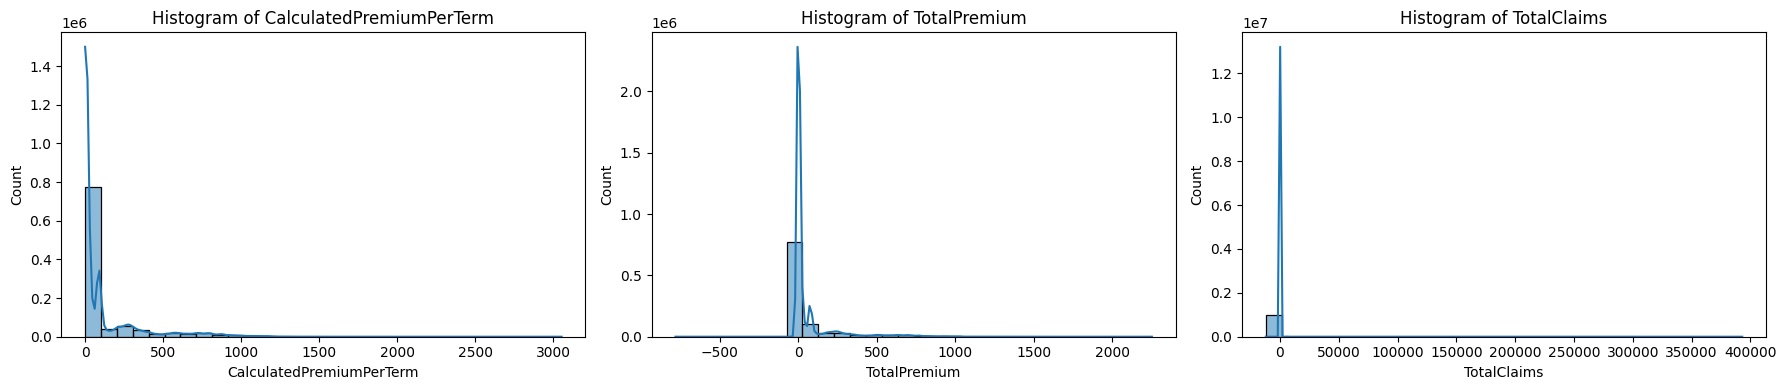

In [8]:
# Plot histograms for major columns
from scripts.plot_generator import PlotGenerator

plotter = PlotGenerator()
plotter.plot_histogram(df=df, columns=["CalculatedPremiumPerTerm", "TotalPremium", "TotalClaims"])

2025-06-15 19:31:41,678 - INFO - Histogram for cubiccapacity created successfully.
2025-06-15 19:31:47,302 - INFO - Histogram for kilowatts created successfully.


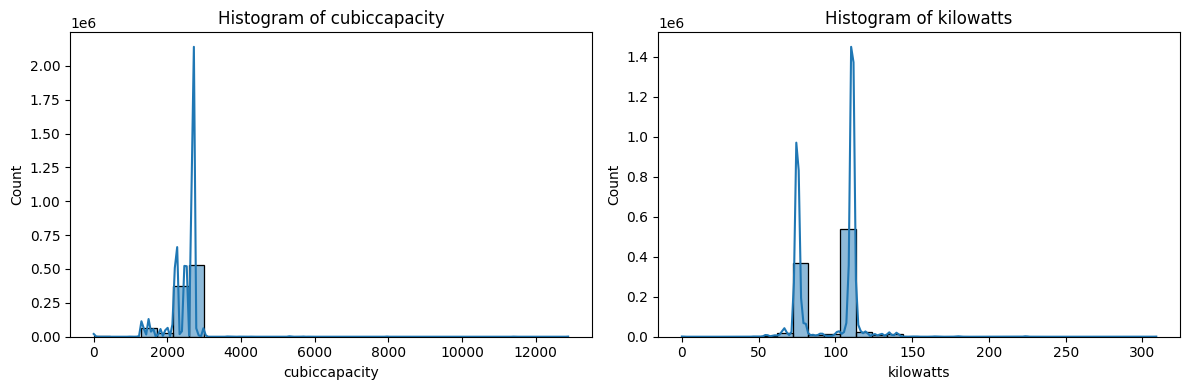

In [9]:
# Plot histograms for vehicle specifications
plotter.plot_histogram(df=df, columns=["cubiccapacity", "kilowatts"])

### Bar chart of categorical data

2025-06-15 19:40:13,834 - INFO - Bar chart for Gender created successfully.
2025-06-15 19:40:14,033 - INFO - Bar chart for Province created successfully.
2025-06-15 19:40:14,218 - INFO - Bar chart for VehicleType created successfully.
2025-06-15 19:40:14,288 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-15 19:40:14,297 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-15 19:40:14,342 - INFO - Bar chart for Cylinders created successfully.


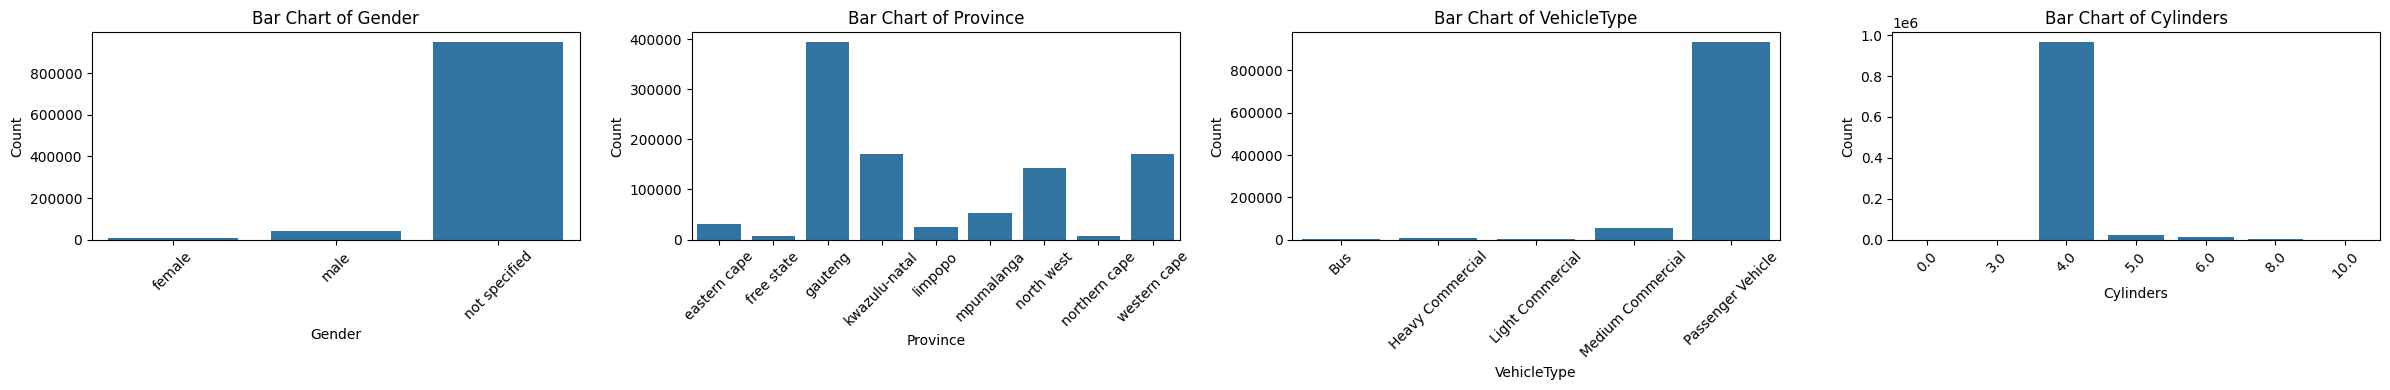

In [12]:
# Generate bar charts for categorical columns
plotter.plot_bar_chart(df=df, columns=["Gender", "Province", "VehicleType", "Cylinders"])

### Loss ratio by category

In [38]:
# Add a column for ratio and replace infinte and Na values with 0
import numpy as np
df["LossRatio"] = df["TotalClaims"] / df["TotalPremium"]
df["LossRatio"] = df["LossRatio"].replace([np.inf, -np.inf], np.nan).fillna(0)

2025-06-15 20:08:05,827 - INFO - Grouped bar chart for LossRatio by ['Province'] created successfully.


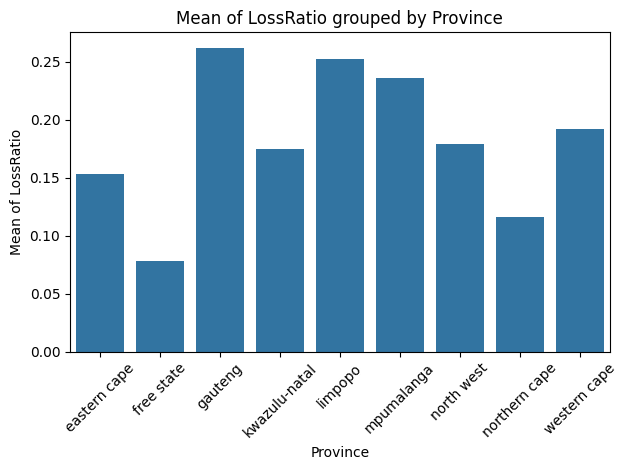

In [39]:
# Create bar chart of Loss ratio by Province
plotter.plot_grouped_bar_chart(df=df, column="LossRatio", group_by="Province")

2025-06-15 20:08:41,819 - INFO - Grouped bar chart for LossRatio by ['VehicleType'] created successfully.


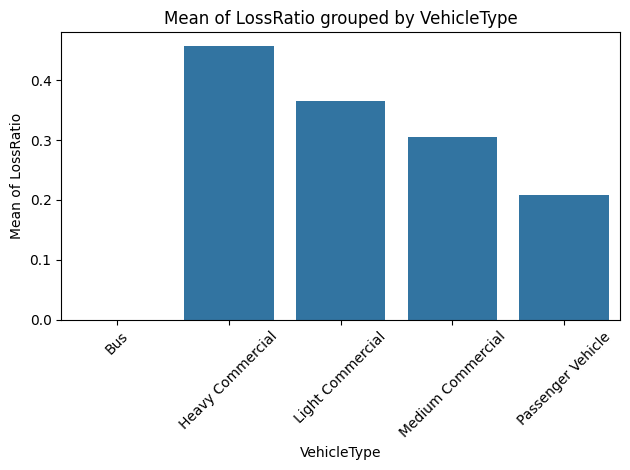

In [40]:
# Create bar chart of Loss ratio by Vehicle Type
plotter.plot_grouped_bar_chart(df=df, column="LossRatio", group_by="VehicleType")

2025-06-15 20:09:15,299 - INFO - Grouped bar chart for LossRatio by ['Gender'] created successfully.


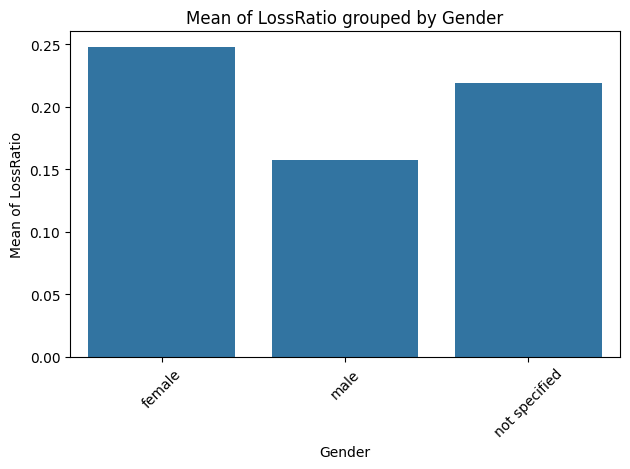

In [41]:
# Create bar chart of Loss ratio by Gender
plotter.plot_grouped_bar_chart(df=df, column="LossRatio", group_by="Gender")

### Temporal Analysis

2025-06-15 20:39:27,184 - INFO - Monthly aggregation completed successfully.


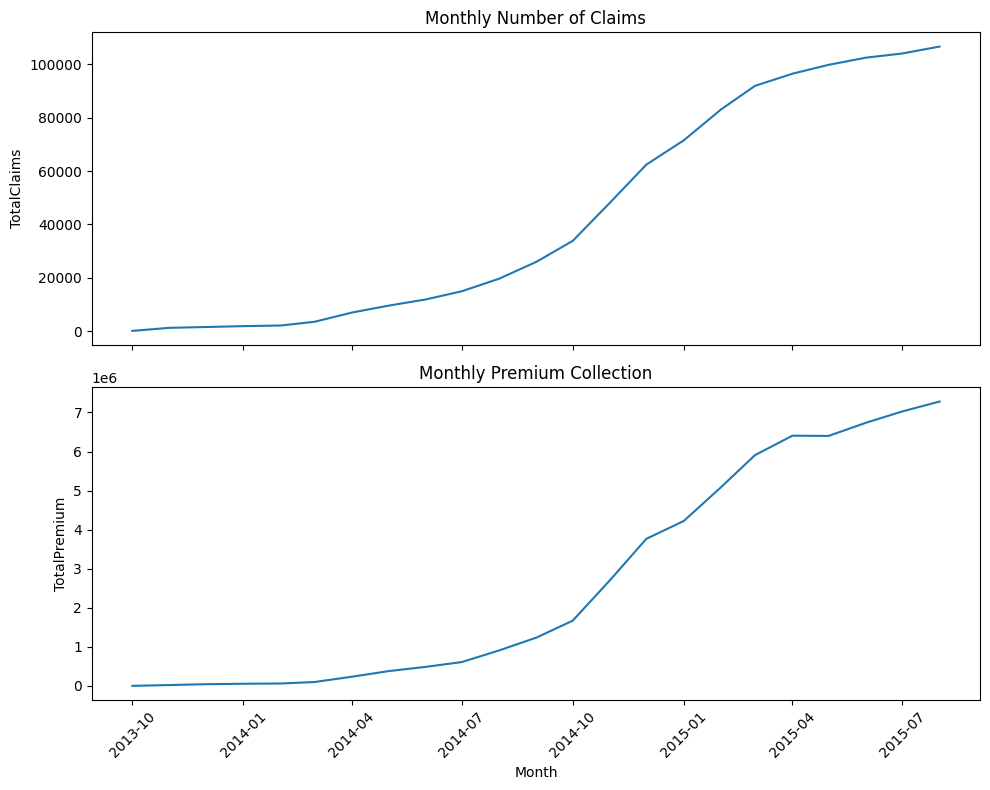

2025-06-15 20:39:29,381 - INFO - Monthly trend plots generated successfully.


In [48]:
# Inside your class:
plotter.plot_monthly_trends(
    df=df,
    date_col="TransactionMonth",
    agg_config={
        "TotalClaims": "count",
        "TotalPremium": "sum"
    },
    title_map={
        "TotalClaims": "Monthly Number of Claims",
        "TotalPremium": "Monthly Premium Collection"
    }
)


## Vehicle make/model claim distribution

In [50]:
# Aggregate data by make and model to find the average number of claims
make_model_avg = df.groupby(["make", "Model"])["TotalClaims"].mean().reset_index()
make_model_avg = make_model_avg.sort_values(by="TotalClaims", ascending=False)

In [52]:
top_10_highest = make_model_avg.head(10)
top_10_highest

,make,Model,TotalClaims
311,TOYOTA,L/CRUISER FJ 4.0 V6 CRUISER,5340.970273
83,HYUNDAI,H-1 2.5 CRDI WAGON A/T,4118.181043
53,FIAT,DUCATO 2.3 JTD VETRATO,1014.681021
394,VOLKSWAGEN,POLO VIVO 1.6 5Dr,827.558882
130,MERCEDES-BENZ,C180 BE COUPE,743.459027
162,MERCEDES-BENZ,SPRINTER 312D F/C P/V,664.540138
246,SUZUKI,ERTIGA 1.4 GA,631.774519
337,TOYOTA,YARIS T1 3Dr,618.719846
4,AUDI,A4 1.8T S AVANT MULTITRONIC,480.282859
387,VOLKSWAGEN,POLO 1.6 COMFORTLINE,431.842105


In [53]:
top_10_lowest = make_model_avg.tail(10)
top_10_lowest

,make,Model,TotalClaims
209,NISSAN,ALMERA 1.6 LUXURY (H02),0.000000
210,NISSAN,ALMERA 1.6 LUXURY (H15/H26),0.000000
212,NISSAN,GRAND LIVINA 1.6 ACENTA,0.000000
213,NISSAN,INTERSTAR 2.5 dCi SR F/C P/V,0.000000
214,NISSAN,LIVINA 1.6 ACENTA,0.000000
215,NISSAN,LIVINA 1.6 VISIA X-GEAR,0.000000
216,NISSAN,MICRA 1.4 VISIA 5Dr (D62/73),0.000000
218,NISSAN,NAVARA 2.5 dCi XE 4X4 P/U D/C,0.000000
207,NISSAN,ALMERA 1.6 COMFORT (H01),0.000000
145,MERCEDES-BENZ,C200K CLASSIC A/T,-0.250832


/home/miki/Desktop/KIFIYA/week-3/Insurance-risk-analysis/scripts/plot_generator.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


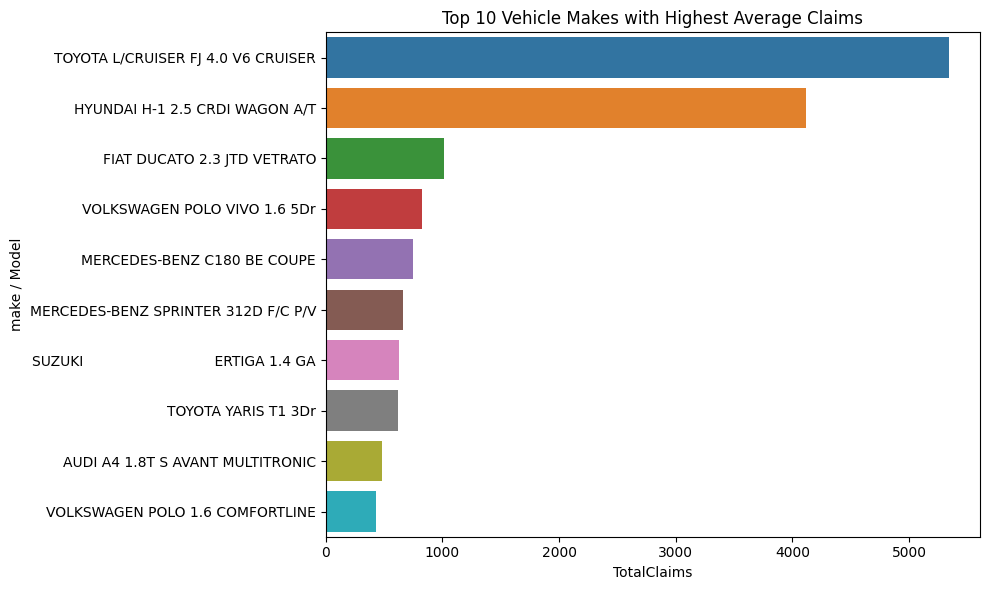

2025-06-15 20:54:51,781 - INFO - Horizontal bar chart 'Top 10 Vehicle Makes with Highest Average Claims' generated successfully.


In [57]:
plotter.plot_horizontal_bar(df=top_10_highest, x_col="TotalClaims", y_col=("make", "Model"), title="Top 10 Vehicle Makes with Highest Average Claims")

/home/miki/Desktop/KIFIYA/week-3/Insurance-risk-analysis/scripts/plot_generator.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


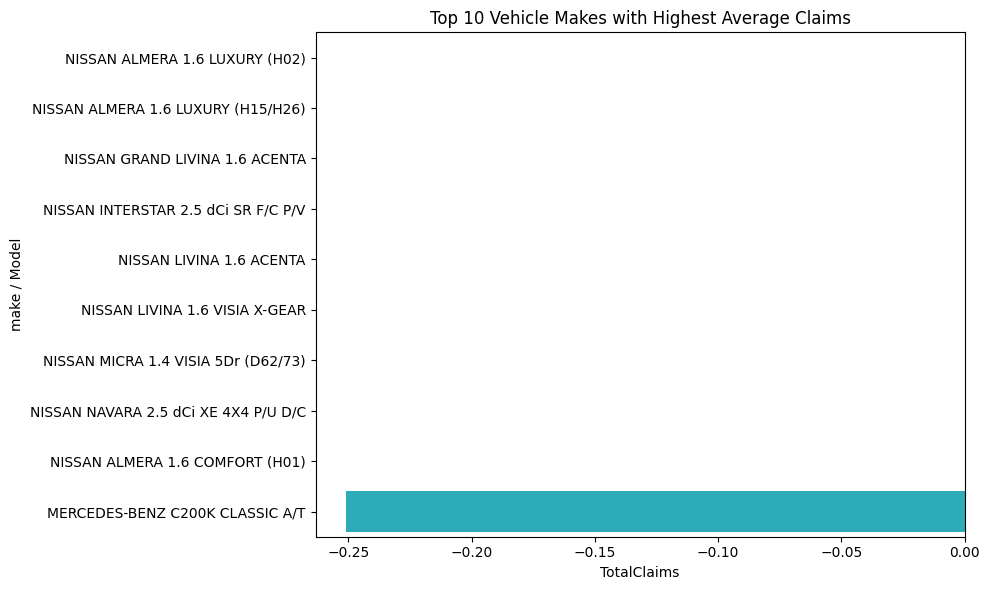

2025-06-15 20:55:45,795 - INFO - Horizontal bar chart 'Top 10 Vehicle Makes with Highest Average Claims' generated successfully.


In [58]:
plotter.plot_horizontal_bar(df=top_10_lowest, x_col="TotalClaims", y_col=("make", "Model"), title="Top 10 Vehicle Makes with Highest Average Claims")

## Correlation and Feature Relationship Mapping

In [61]:
import importlib
from scripts import plot_generator
importlib.reload(plot_generator)
from scripts.plot_generator import PlotGenerator
plotter = PlotGenerator()

2025-06-15 21:29:47,899 - INFO - PlotGenerator initialized


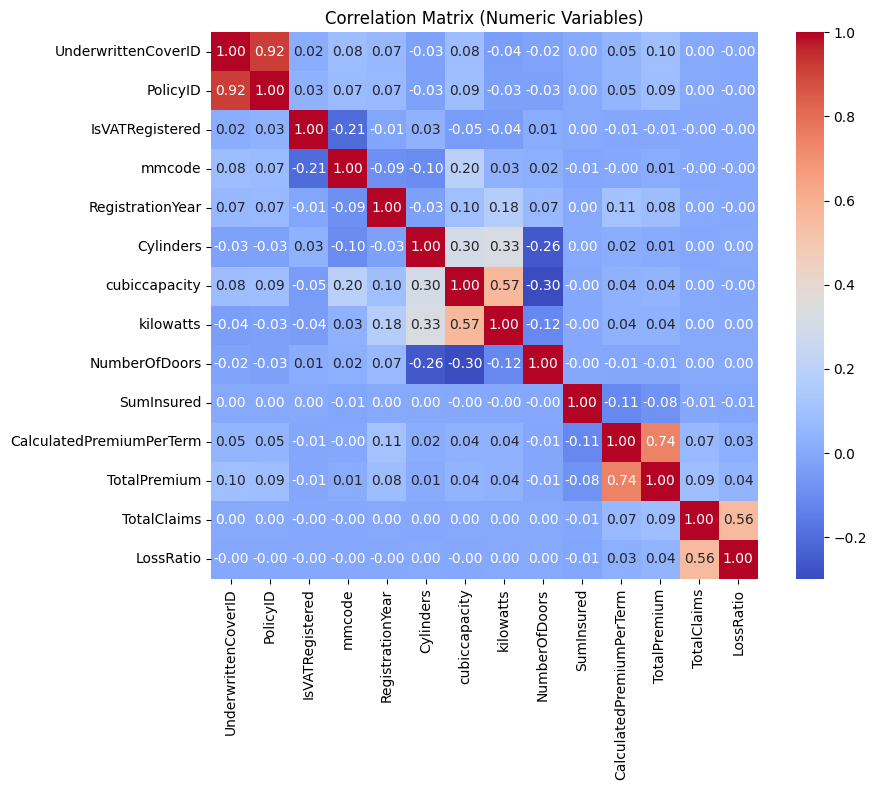

2025-06-15 21:28:10,340 - INFO - Correlation matrix heatmap generated successfully.


In [60]:
plotter.plot_correlation_matrix(df)

2025-06-15 21:30:03,759 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-15 21:30:04,710 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


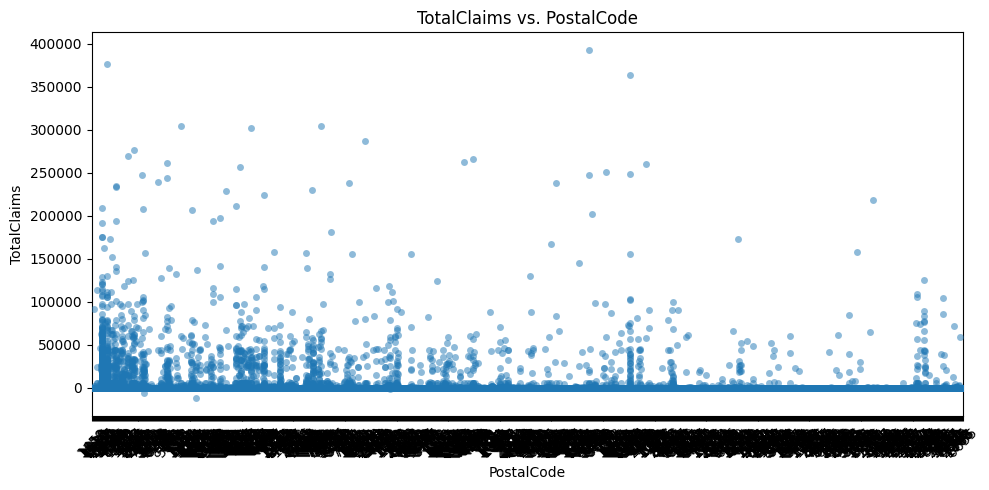

2025-06-15 21:30:17,492 - INFO - Scatter plot for TotalClaims vs. PostalCode generated.
2025-06-15 21:30:20,225 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-15 21:30:21,577 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


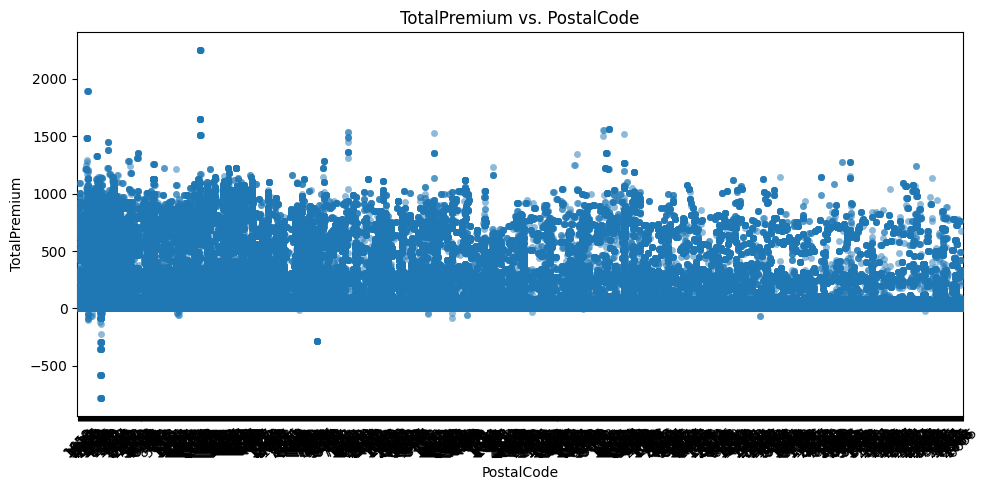

2025-06-15 21:30:36,258 - INFO - Scatter plot for TotalPremium vs. PostalCode generated.


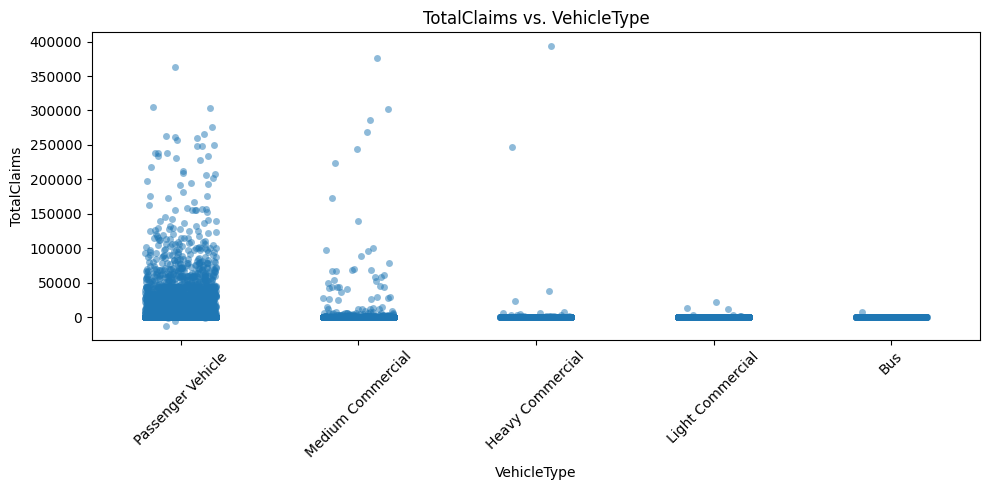

2025-06-15 21:30:41,274 - INFO - Scatter plot for TotalClaims vs. VehicleType generated.


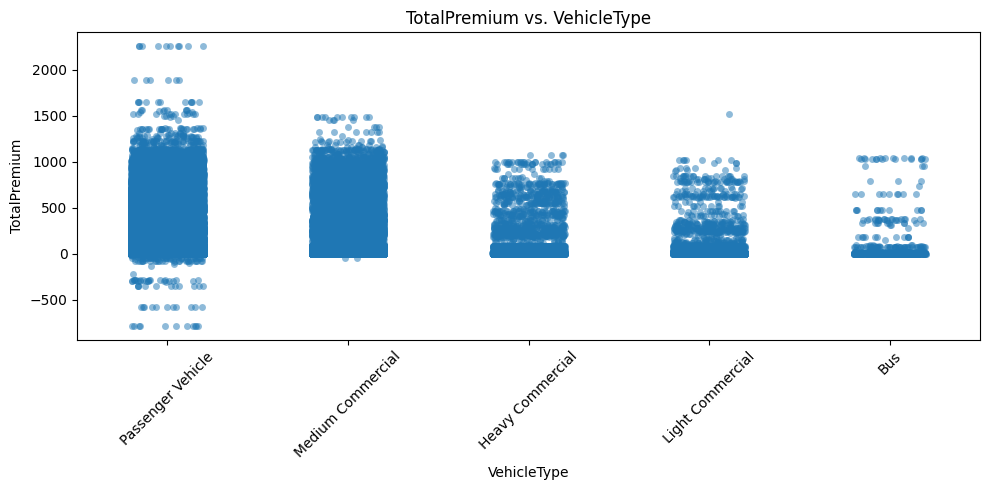

2025-06-15 21:30:47,212 - INFO - Scatter plot for TotalPremium vs. VehicleType generated.


In [62]:
plotter.plot_scatter_by_category(
    df=df,
    numeric_cols=["TotalClaims", "TotalPremium"],
    categorical_cols=["PostalCode", "VehicleType"]
)